# Home Credit Scorecard Model
**Name** : Azarya Yehezkiel Pinondang Sipahutar <br><br>
**Project Goal** : To develop a scorecard model to predict the probability of a customer to default on a loan. <br><br>
**Project Objective** : 

Pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman, dan pinjaman dapat diberikan dengan principal, maturity, dan repayment calendar yang akan memotivasi pelanggan untuk sukses

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

## Load Data

In [2]:
# original data
app_train = pd.read_csv('./data/application_train.csv')
app_test = pd.read_csv('./data/application_test.csv')
bureau = pd.read_csv('./data/bureau.csv')
bureau_balance = pd.read_csv('./data/bureau_balance.csv')
ccb = pd.read_csv('./data/credit_card_balance.csv')
ip = pd.read_csv('./data/installments_payments.csv')
pb = pd.read_csv('./data/POS_CASH_balance.csv')
pa = pd.read_csv('./data/previous_application.csv')


# sample data
train_sample = app_train.sample(frac=0.05,random_state=7)
test_sample = app_test.sample(frac=0.05,random_state=7)
bureau_sample = bureau.sample(frac=0.05,random_state=7)
bb_sample = bureau_balance.sample(frac=0.05,random_state=7)    
ccb_sample = ccb.sample(frac=0.05,random_state=7)
ip_sample = ip.sample(frac=0.05,random_state=7)
pb_sample = pb.sample(frac=0.05,random_state=7)
pa_sample = pa.sample(frac=0.05,random_state=7)

In [3]:
pd.set_option('display.max_columns', None)

## Data Cleaning and Processing

In [4]:
# function to drop columns with missing values
def dropna(df, threshold=0.45, /):
    '''
    Drop columns from a DataFrame where the proprortion of missing values is greater than specified threshold.

    Parameters:
    df: The DataFrame to process
    threshold: The threshold proportion of missing vales. Columns with a proportion of missing values greater than this will be dropped.

    Returns:
    Pandas.DataFrame: The processed DataFrame. 
    '''
    for column in df.columns:
        missing_proportion = df[column].isnull().sum() / len(df)
        if missing_proportion > threshold:
            df = df.drop(column, axis=1)
    return df

# function to plot missing value percentage
def plot_missing_percentage(df):
    """
    Plot the percentage of missing values for each column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process.
    """
    # Calculate the percentage of missing values
    missing = df.isnull().sum() * 100 / len(df)

    # Create a DataFrame with the results
    percentage_missing = pd.DataFrame({'column': df.columns, 'missing_percentage %': missing.values})
    percentage_missing['missing_percentage %'] = percentage_missing['missing_percentage %'].round(2)
    percentage_missing = percentage_missing.sort_values('missing_percentage %', ascending=False)
    percentage_missing = percentage_missing.reset_index()
    percentage_missing = percentage_missing.drop('index', axis=1)

    # Plot the results
    plt.figure(figsize=(15, 20))
    ax = sns.barplot(x='missing_percentage %', y='column', data=percentage_missing, color='#E1341E')
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_width() + '%', xy=(p.get_width(), p.get_y()+p.get_height()/2),
                    xytext=(8, 0), textcoords='offset points', ha="left", va="center", fontsize=10)
    plt.title('Missing values Percentage for Each Column', fontsize=17, fontweight='bold')
    plt.ylabel('Kolom', fontsize=12)
    plt.xlabel('missing_percentage %', fontsize=12)
    plt.tight_layout()
    plt.xlim(0, 100)
    plt.show()

In [5]:
# merge the data
bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left', suffixes=('_bureau', '_bb'))

train_bureau = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('', '_bureau_bb'))
test_bureau = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('', '_bureau_bb'))

# merge previous applications
pa_pos = pd.merge(pa_sample, pb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_pb'))
pa_cb = pd.merge(pa_pos, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa_pb', '_ccb'))
pa_full = pd.merge(pa_cb, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa_pb_ccb', '_ip'))
pa_full.rename(columns={'SK_ID_CURR_pa': 'SK_ID_CURR'}, inplace=True)

train_full = pd.merge(train_bureau, pa_full, on='SK_ID_CURR', how='inner', suffixes=('_CURR', '_PREV'))
test_full = pd.merge(test_bureau, pa_full, on='SK_ID_CURR', how='inner', suffixes=('_CURR', '_PREV'))

# Drop the right dataframe's columns
train_full = train_full[train_full.columns.drop(list(train_full.filter(regex='_bb|_bureau_bb|_pb|_pa_pb|_ccb|_pa_pb_ccb|_ip|_pa_full')))]
test_full = test_full[test_full.columns.drop(list(test_full.filter(regex='_bb|_bureau_bb|_pb|_pa_pb|_ccb|_pa_pb_ccb|_ip|_pa_full')))]

print(train_full.shape)
print(test_full.shape)

(5690, 201)
(1257, 200)


In [6]:
# Create a list of dataframes to clean
df2clean = [train_full, test_full]

# Loop through the list and clean each dataframe by dropping NA values
for i, df in enumerate(df2clean):
    df2clean[i] = dropna(df)

# Unpack the cleaned dataframes back into their original variables
train_full, test_full = df2clean

# Get a list of column names from the train dataframe, excluding the 'TARGET' column
traincol = train_full.drop('TARGET', axis=1).columns

# Restrict the columns in the test dataframe to match those in the train dataframe
test_full = test_full[traincol]

# Print the shape of the dataframes to check the number of rows and columns
print(train_full.shape)
print(test_full.shape)

(5690, 104)
(1257, 103)


train data: 
(5690, 104)


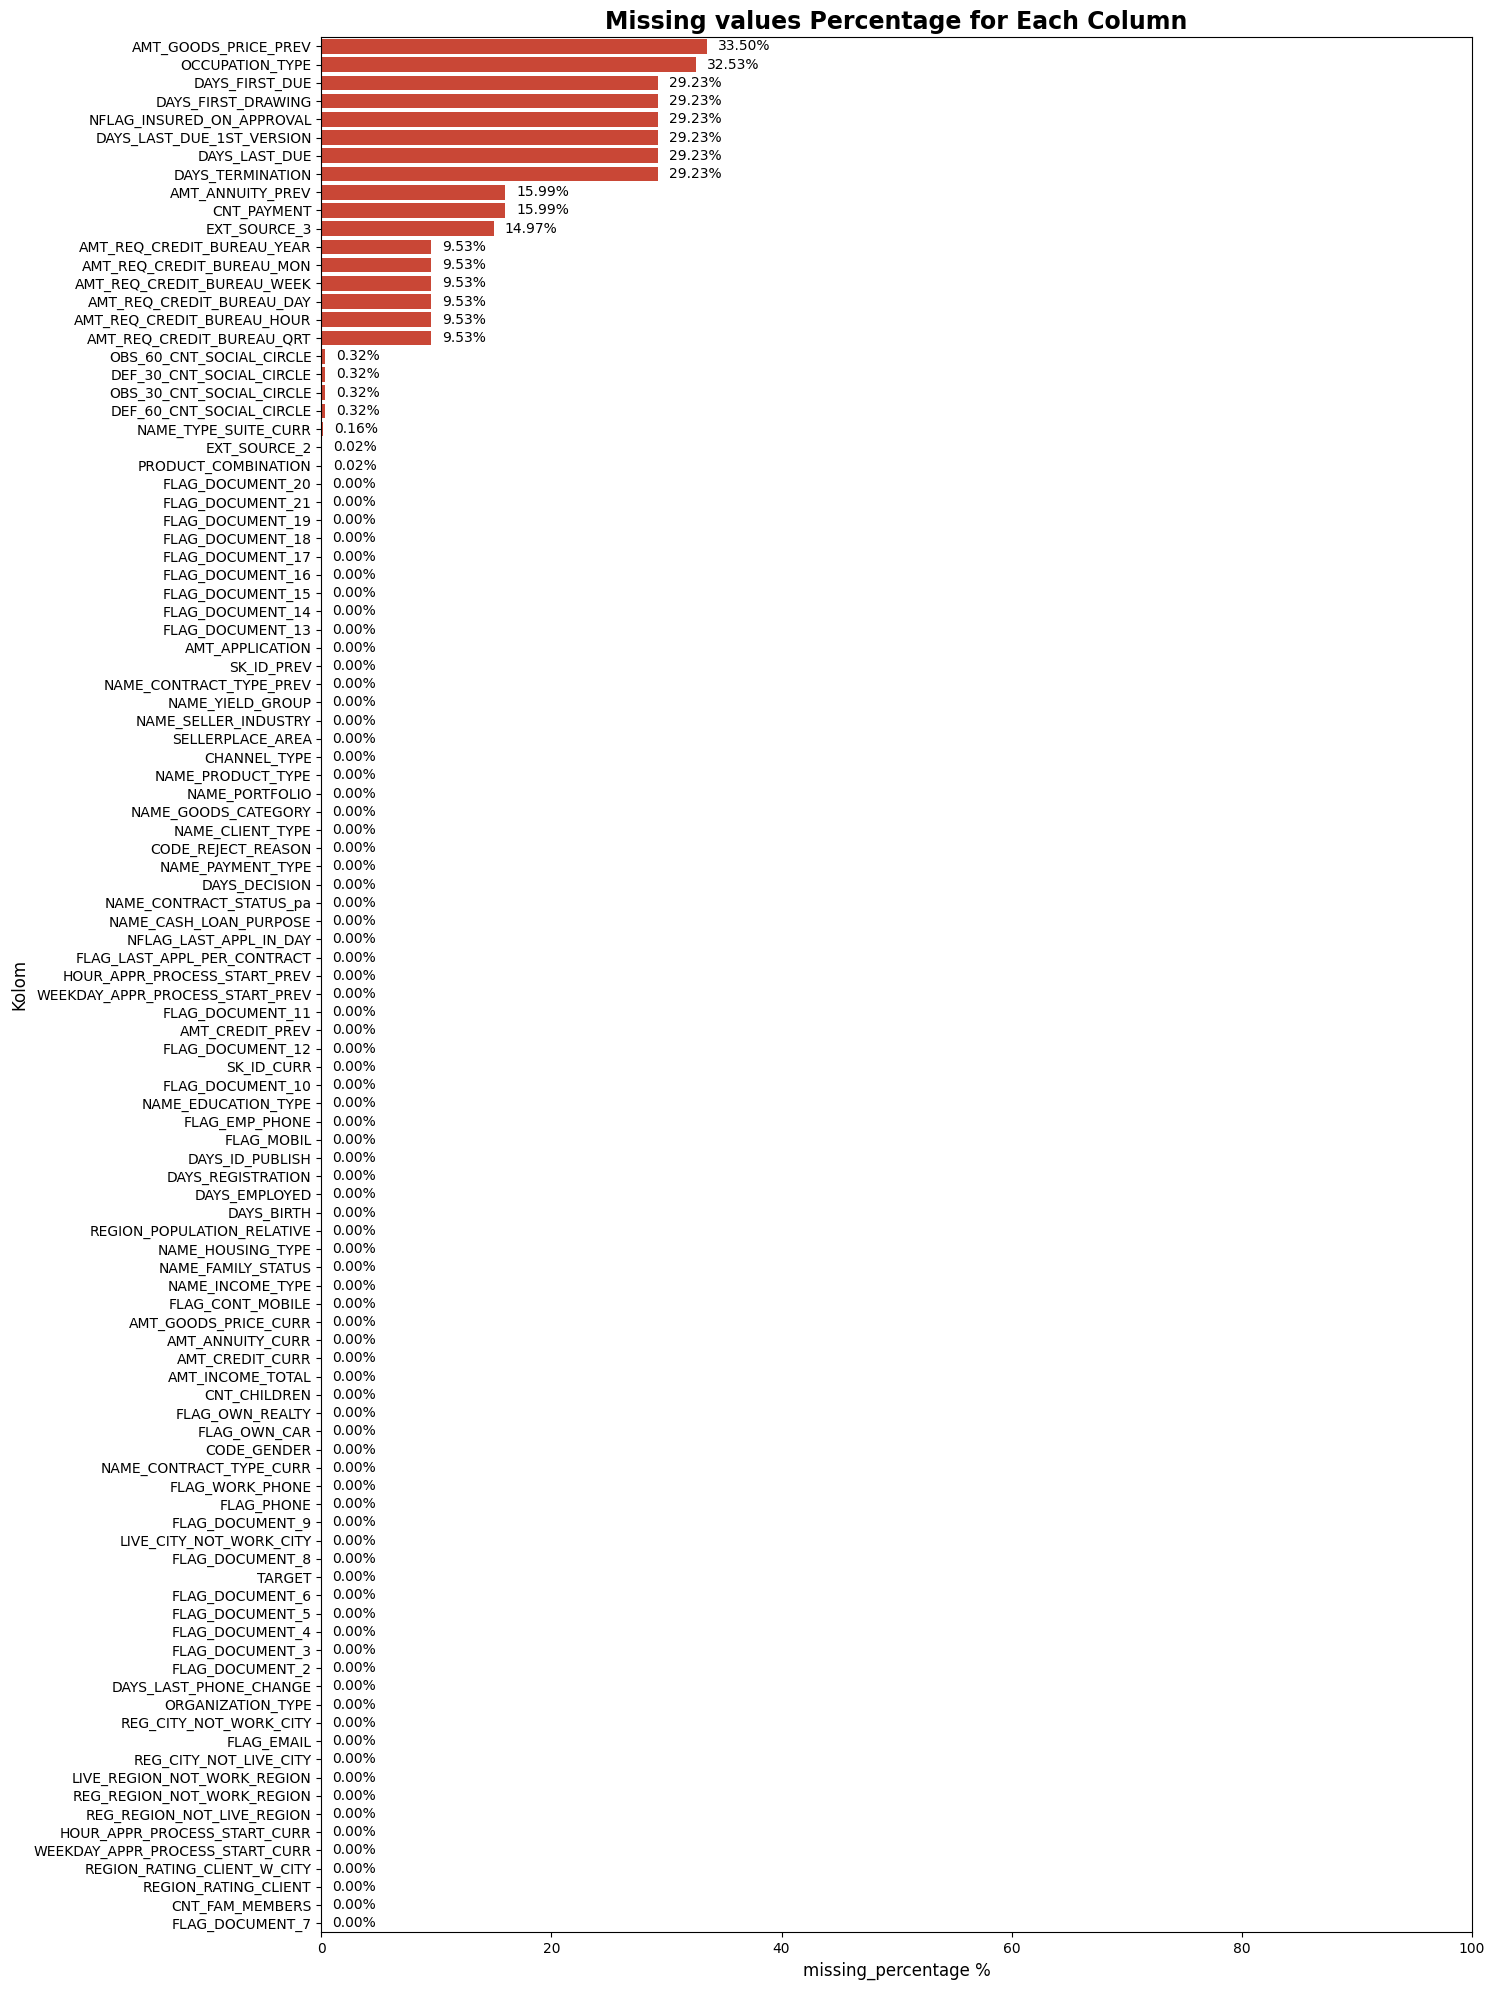

None

test data: 
(1257, 103)


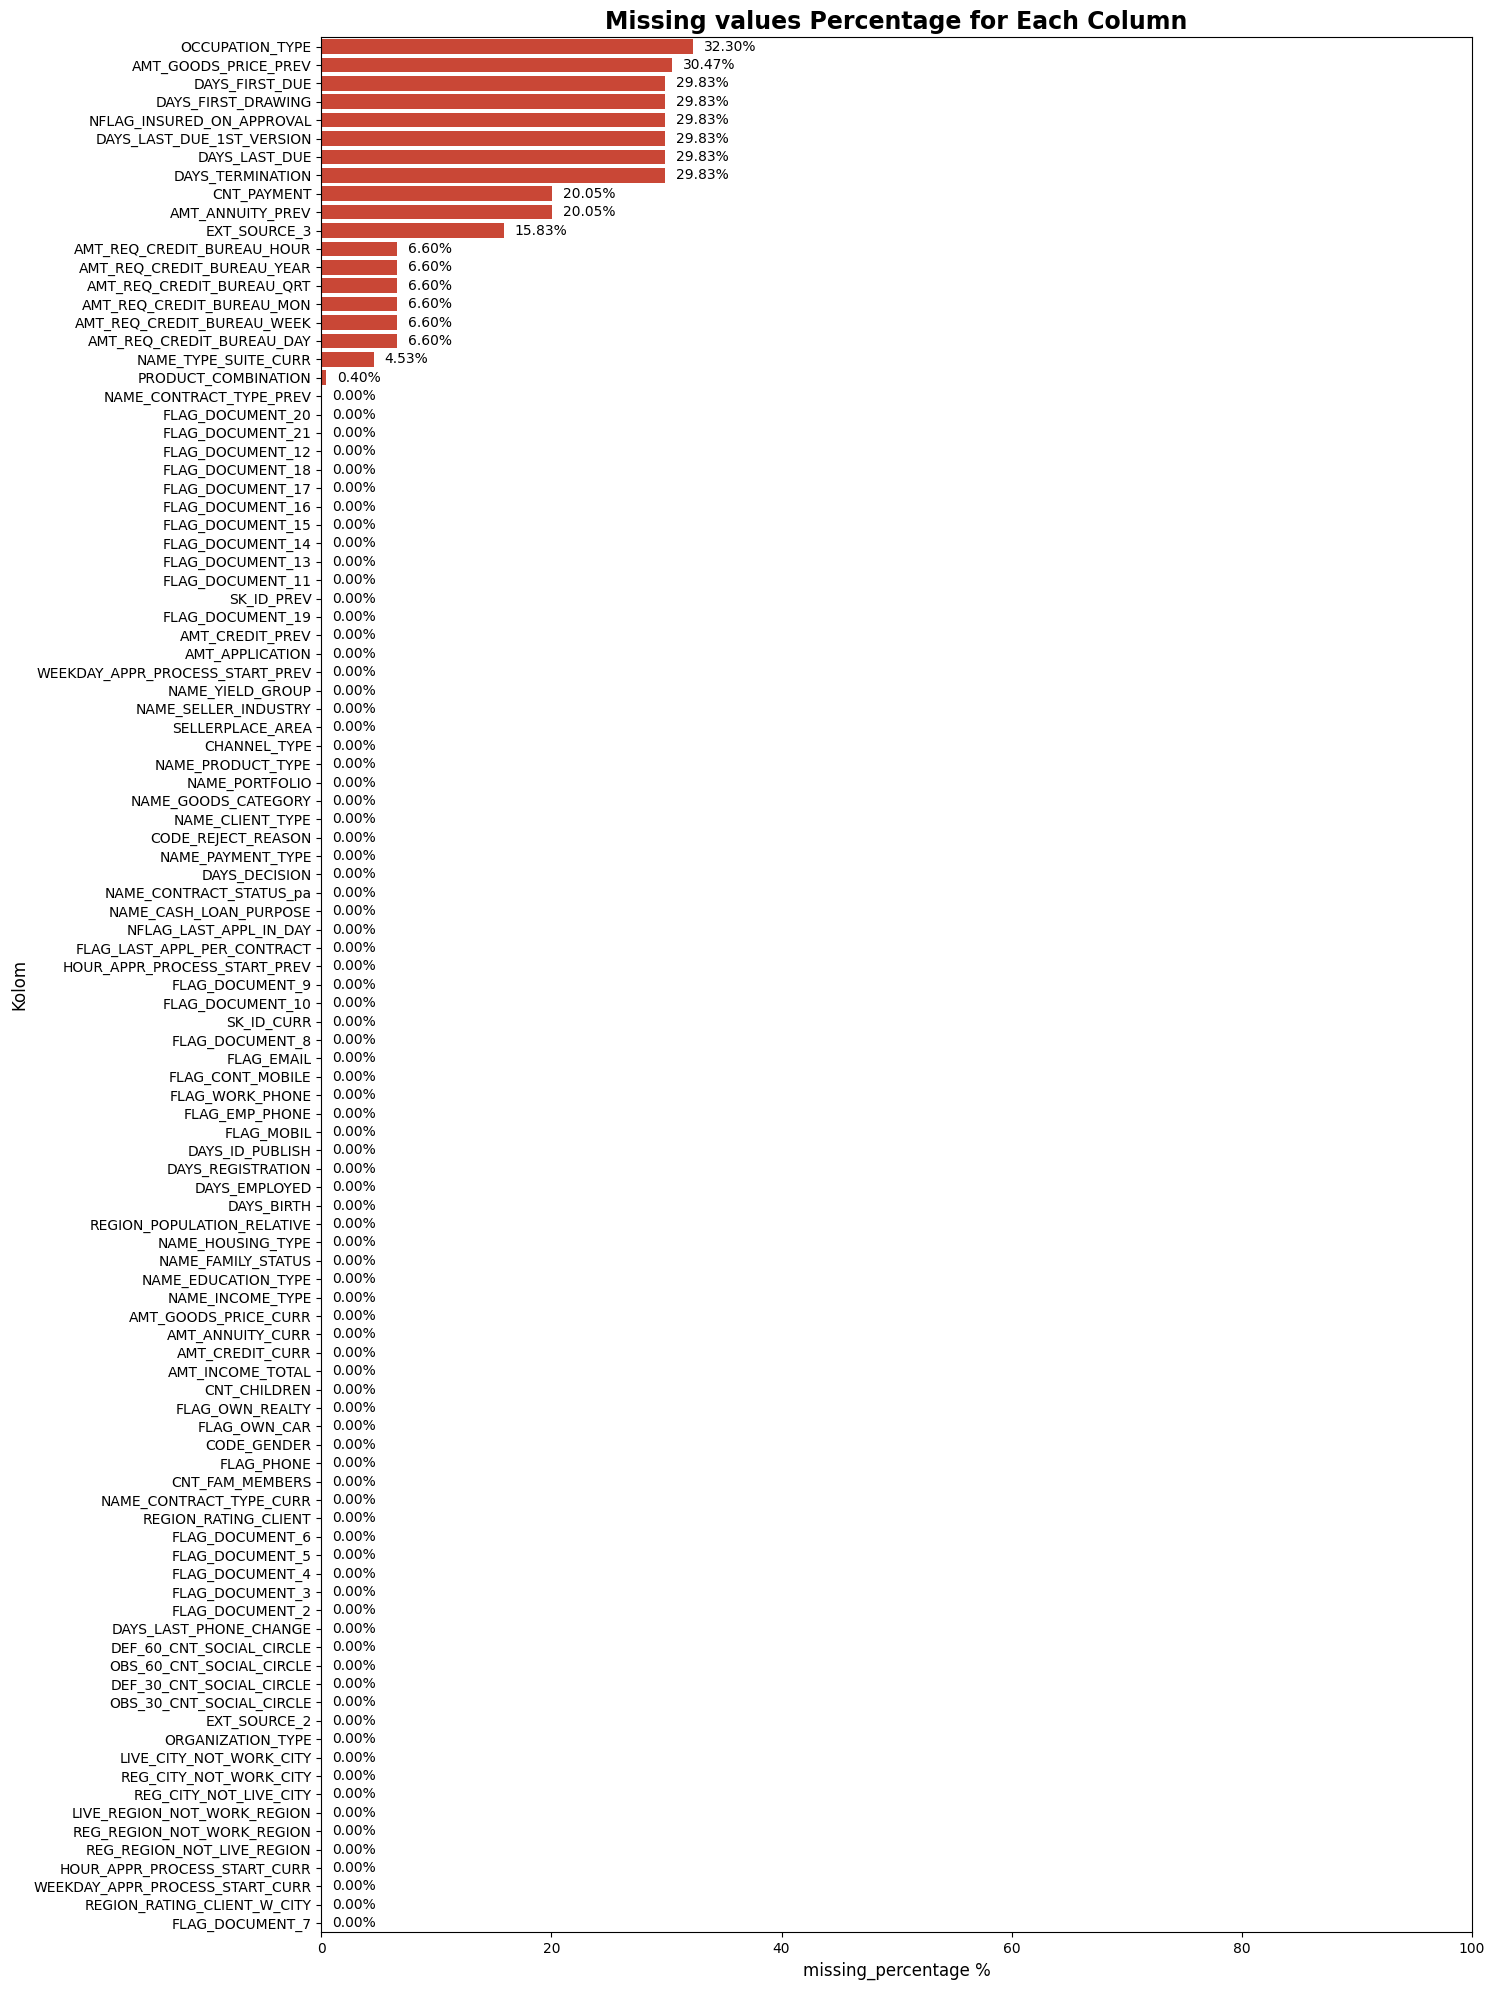

None

In [7]:
train_full = dropna(train_full)
print(f'train data: \n{train_full.shape}')
display(plot_missing_percentage(train_full))

test_full = dropna(test_full)
print(f'test data: \n{test_full.shape}')
display(plot_missing_percentage(test_full))

## EDA

In [8]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5690 entries, 0 to 5689
Columns: 104 entries, SK_ID_CURR to NFLAG_INSURED_ON_APPROVAL
dtypes: float64(31), int64(46), object(27)
memory usage: 4.5+ MB


In [9]:
num = train_full.select_dtypes(include=['int64', 'float64'])
ctg = train_full.select_dtypes(include='object')

# show numerical data statistics
print('Numerical data statistics:')
display(num.describe())

# show categorical data statistics
print('\nCategorical data statistics')
display(ctg.describe())

Numerical data statistics:


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_CURR,AMT_ANNUITY_CURR,AMT_GOODS_PRICE_CURR,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_CURR,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV,AMT_ANNUITY_PREV,AMT_APPLICATION,AMT_CREDIT_PREV,AMT_GOODS_PRICE_PREV,HOUR_APPR_PROCESS_START_PREV,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,5690.000000,5690.000000,5690.000000,5690.000000,5.690000e+03,5690.000000,5.690000e+03,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.0,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5689.000000,4838.000000,5672.000000,5672.000000,5672.000000,5672.000000,5690.000000,5690.0,5690.000000,5690.000000,5690.000000,5690.000000,5690.0,5690.000000,5690.000000,5690.0,5690.000000,5690.0,5690.000000,5690.000000,5690.000000,5690.000000,5690.0,5690.000000,5690.000000,5690.000000,5690.000000,5148.000000,5148.000000,5148.000000,5148.000000,5148.000000,5148.000000,5.690000e+03,4780.000000,5.690000e+03,5.690000e+03,3.784000e+03,5690.000000,5690.000000,5690.000000,5690.000000,4780.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000
mean,272098.559227,0.084359,0.390685,174259.505009,5.986221e+05,27715.919156,5.370500e+05,0.020144,-16662.093849,75481.635149,-5476.473286,-3149.857645,1.0,0.787873,0.177153,0.999649,0.279613,0.086467,2.128647,2.068893,2.036731,12.113357,0.008436,0.037961,0.033919,0.082074,0.199824,0.150088,0.520562,0.491513,1.516396,0.143688,1.494358,0.102433,-1165.901406,0.0,0.760984,0.000176,0.013708,0.105624,0.0,0.057469,0.002460,0.0,0.000703,0.0,0.000527,0.000527,0.000351,0.006151,0.0,0.004042,0.001582,0.000176,0.000176,0.004468,0.009130,0.025641,0.364025,0.319736,2.890831,1.922731e+06,14608.244542,1.570674e+05,2.045811e+05,2.361822e+05,12.363445,0.997540,-1155.832337,279.317575,13.830544,261812.647380,8172.628756,109929.204370,78049.221505,119941.553017,0.259995
std,103378.208124,0.277949,0.705116,86861.611908,3.770666e+05,14076.098437,3.466316e+05,0.012377,4183.912174,150380.454700,3685.045825,1512.230948,0.0,0.408850,0.381832,0.018747,0.448849,0.281078,0.892719,0.474891,0.468243,3.099677,0.091467,0.191120,0.181037,0.274501,0.399903,0.357189,0.184830,0.194783,2.454110,0.435162,2.412636,0.353706,817.891770,0.0,0.426520,0.013257,0.116287,0.307383,0.0,0.232757,0.049546,0.0,0.026507,0.0,0.022958,0.022958,0.018747,0.078195,0.0,0.063455,0.039743,0.013257,0.013257,0.066698,0.095122,0.169924,1.124278,0.681960,2.135249,5.266288e+05,14391.769666,2.801547e+05,2.990767e+05,3.151831e+05,3.313003,0.049546,918.705566,952.611761,14.909764,165223.353226,58438.374359,168044.653505,150784.154260,172186.058503,0.438686
min,100073.000000,0.000000,0.000000,27000.000000,4.500000e+04,2164.500000,4.500000e+04,0.001276,-25081.000000,-16424.000000,-22858


Categorical data statistics


,NAME_CONTRACT_TYPE_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE_CURR,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START_CURR,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_PREV,WEEKDAY_APPR_PROCESS_START_PREV,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS_pa,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,5690,5690,5690,5690,5681,5690,5690,5690,5690,3839,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5689
unique,2,2,2,2,7,4,5,5,6,18,7,53,4,7,2,18,4,4,8,4,21,5,3,8,10,5,17
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Cash loans,FRIDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Card Street
freq,5378,3983,3933,4240,4589,2835,4229,3656,5181,1100,1033,1295,2166,929,5674,3524,4147,3029,4918,4303,3614,1999,2922,2224,2734,2250,870


The categorical data unique values > 1 means that the categorical data is valid. 

In [15]:
td = train_full.copy()

In [ ]:
td.groupby(['TARGET', 'NAME_CONTRACT_STATUS_pa'])['AMT_INCOME_TOTAL'].sum().to_frame().plot(kind='bar', figsize=(10, 6))

td.groupby(['TARGET', 'NAME_CONTRACT_STATUS_pa'])['AMT_CREDIT_CURR'].sum().to_frame().plot(kind='bar', figsize=(10, 6))




0         0.0
1    990000.0
2    450000.0
3     31203.0
4         0.0
Name: AMT_APPLICATION, dtype: float64
0          0.0
1    1076247.0
2     512370.0
3      31203.0
4          0.0
Name: AMT_CREDIT_PREV, dtype: float64


<Axes: xlabel='CODE_REJECT_REASON'>

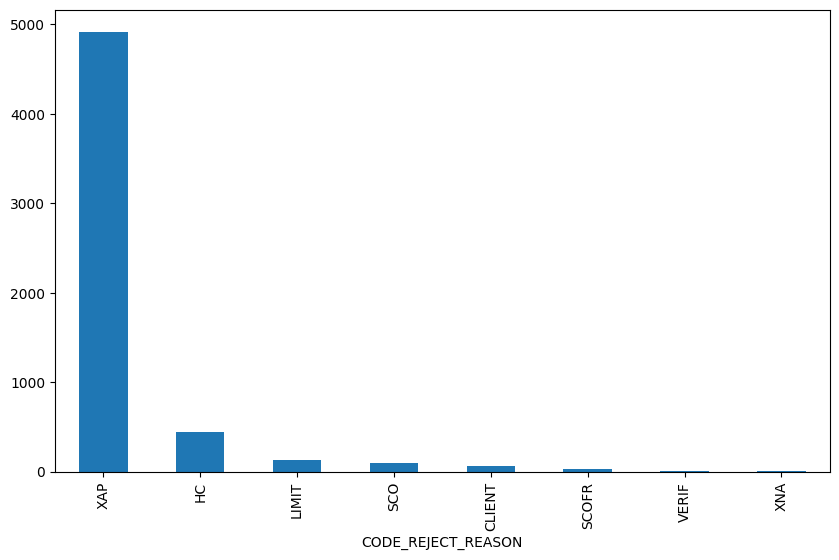

In [142]:
print(td.AMT_APPLICATION.head())
print(td.AMT_CREDIT_PREV.head())
td.CODE_REJECT_REASON.value_counts().plot(kind='bar', figsize=(10, 6))

In [82]:
from fuzzywuzzy import process

column_names = train_full.columns.tolist()
bm = process.extract('NAME_CONTRACT_STATUS', column_names)
bm

[('NAME_CONTRACT_STATUS_pa', 93),
 ('NAME_CONTRACT_TYPE_CURR', 74),
 ('NAME_CONTRACT_TYPE_PREV', 70),
 ('NAME_FAMILY_STATUS', 68),
 ('NAME_PRODUCT_TYPE', 54)]

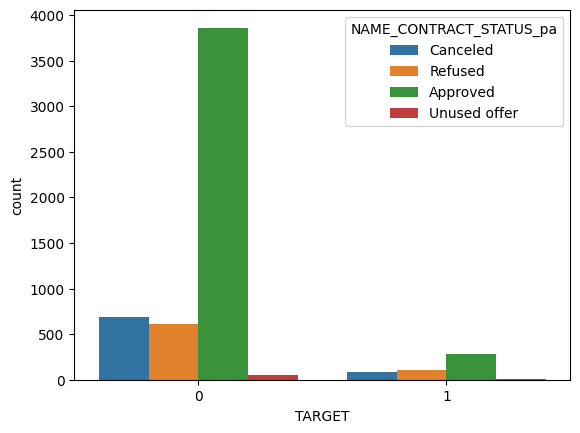

In [86]:
sns.countplot(x='TARGET', hue='NAME_CONTRACT_STATUS_pa', data=td)
plt.show()

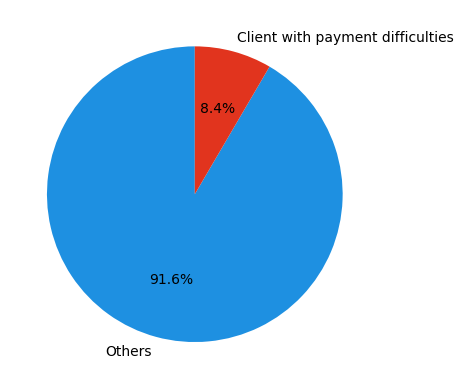

In [75]:
plt.pie(td['TARGET'].value_counts(), labels=['Others', 'Client with payment difficulties'], autopct='%1.1f%%', startangle=90, colors=['#1E90E1', '#E1341E'])
plt.show()

<Axes: xlabel='TARGET'>

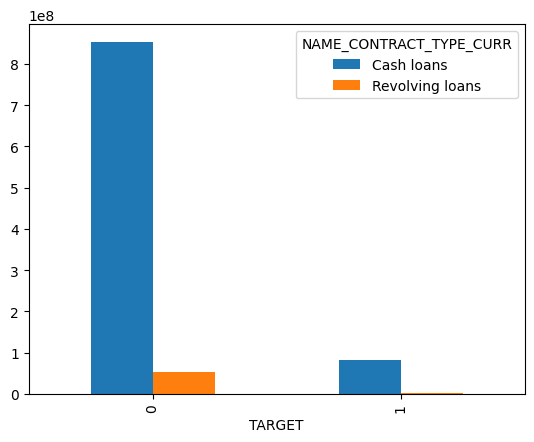

In [69]:
td.groupby(['TARGET', 'NAME_CONTRACT_TYPE_CURR'])['AMT_INCOME_TOTAL'].sum().unstack().plot(kind='bar')

In [ ]:
time_feat = ['DAYS_DECISION', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_DECISION', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']

In [ ]:
# copy train test data for processing
tc = train_full.copy()
tsc = test_full.copy()

# add features for better interpretation analysis
tc['AGE'] = round(abs(tc['DAYS_BIRTH'] / 365.25)).astype(int)
tsc['AGE'] = round(abs(tsc['DAYS_BIRTH'] / 365.25)).astype(int)

# days deecision
tc['DAYS_DECISION'] = abs(tc['DAYS_DECISION'])
tsc['DAYS_DECISION'] = abs(tsc['DAYS_DECISION'])
tc['MONTHS_DECISION'] = round(tc['DAYS_DECISION'] / 30).astype(int)
tsc['MONTHS_DECISION'] = round(tsc['DAYS_DECISION'] / 30).astype(int)


# days employed
tc['DAYS_EMPLOYED'] = abs(tc['DAYS_EMPLOYED'])
tsc['DAYS_EMPLOYED'] = abs(tsc['DAYS_EMPLOYED'])

# days registration
tc['DAYS_REGISTRATION'] = abs(tc['DAYS_REGISTRATION'])
tsc['DAYS_REGISTRATION'] = abs(tsc['DAYS_REGISTRATION'])

<Axes: xlabel='TARGET', ylabel='count'>

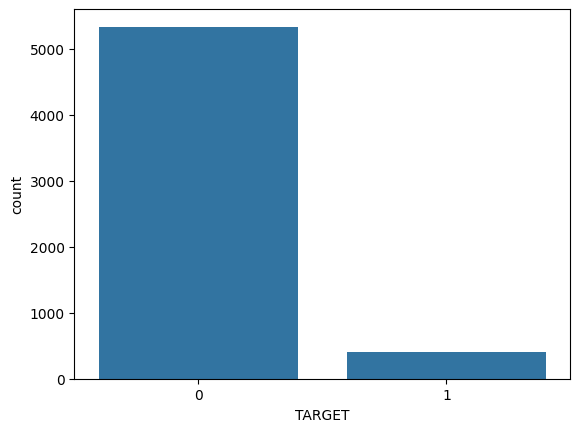

In [59]:
sns.countplot(x='TARGET', data=train_full)

-------

In [ ]:
# df2clean = [train_sample, test_sample, bureau_sample, bb_sample, ccb_sample, ip_sample, pb_sample, pa_sample]

# for i, df in enumerate(df2clean):
#     df2clean[i] = dropna(df)

# train_sample, test_sample, bureau_sample, bb_sample, ccb_sample, ip_sample, pb_sample, pa_sample = df2clean


In [ ]:
# # Merge data
# train_instllmnt = pd.merge(train_sample, ip_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_ip'))
# train_cb = pd.merge(train_instllmnt, ccb_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_ccb'))
# train_pb = pd.merge(train_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pb'))
# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')
# train_semi = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))

# # Train data
# train_full = pd.merge(train_semi, pa_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# test_full = pd.merge(test_sample, pa_sample, on='SK_ID_CURR', how='left')

In [ ]:
# # Merge data
# pa_instllmnt = pd.merge(pa_sample, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ip'))

# pa_cb = pd.merge(pa_instllmnt, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ccb'))

# pa_full = pd.merge(pa_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_pa', '_pb'))

# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')


# # Train data
# tb = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# train_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# tb = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# test_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left')

In [ ]:
# # Select necessary columns
# ip_sample = ip_sample.drop(columns='SK_ID_PREV')
# ccb_sample = ccb_sample.drop(columns='SK_ID_PREV')
# pb_sample = pb_sample.drop(columns='SK_ID_CURR')
# bb_sample = bb_sample.drop(columns='SK_ID_BUREAU')

# # Merge data
# pa_instllmnt = pd.merge(pa_sample, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ip'))
# pa_cb = pd.merge(pa_instllmnt, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ccb'))
# pa_full = pd.merge(pa_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_pa', '_pb'))
# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')

# # Train data
# tb = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# train_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# tb = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# test_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left')

In [ ]:
# # Select the columns you want from each dataframe excluding the identifier column
# ip_sample_selected = ip_sample.drop('SK_ID_PREV', axis=1)
# ccb_sample_selected = ccb_sample.drop('SK_ID_PREV', axis=1)
# pb_sample_selected = pb_sample.drop('SK_ID_CURR', axis=1)
# bureau_merge_selected = bureau_merge.drop('SK_ID_CURR', axis=1)

# # Merge the dataframes
# pa_instllmnt = pd.merge(pa_sample, ip_sample_selected, left_on='SK_ID_PREV', right_index=True, how='left')
# pa_cb = pd.merge(pa_instllmnt, ccb_sample_selected, left_on='SK_ID_PREV', right_index=True, how='left')
# pa_full = pd.merge(pa_cb, pb_sample_selected, left_on='SK_ID_CURR', right_index=True, how='left')

# # Select the columns you want from pa_full excluding the identifier column
# pa_full_selected = pa_full.drop('SK_ID_CURR', axis=1)

# # Merge with train_sample and test_sample
# train_semi = pd.merge(train_sample, pa_full_selected, left_on='SK_ID_CURR', right_index=True, how='left')
# train_full = pd.merge(train_semi, bureau_merge_selected, left_on='SK_ID_CURR', right_index=True, how='left')


# test_semi = pd.merge(test_sample, pa_full_selected, left_on='SK_ID_CURR', right_index=True, how='left')
# test_full = pd.merge(test_semi, bureau_merge_selected, left_on='SK_ID_CURR', right_index=True, how='left')